## Imports & Dataloading

In [1]:
!pip install -q pytorch_lightning wandb einops

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 800.9/800.9 kB 11.0 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.2/2.2 MB 61.2 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 44.6/44.6 kB 6.3 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 840.4/840.4 kB 59.2 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 195.4/195.4 kB 28.1 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 258.5/258.5 kB 31.0 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 62.7/62.7 kB 9.4 MB/s eta 0:00:00


In [2]:
import os

import math
from math import sqrt

import numpy as np

import torch
import torch.nn as nn
from torch.nn import functional as F

import torchvision
from torchvision import transforms

import pytorch_lightning as L
from pytorch_lightning import Trainer
from pytorch_lightning.callbacks import LearningRateMonitor, ModelCheckpoint
from pytorch_lightning.loggers import WandbLogger

import wandb

from einops import rearrange, repeat
from einops.layers.torch import Rearrange

In [3]:
class CIFAR10DataModule(L.LightningDataModule):
    def __init__(self, batch_size):
        super().__init__()
        self.batch_size = batch_size
        # More transformations here in the future?
        self.transform = transforms.Compose([
            transforms.ToTensor(),
            transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5)) # Normalizing in range [-1, 1] for all 3 channels
        ])

    def prepare_data(self):
        if not os.path.exists('./data'):
            os.makedirs('./data')

        torchvision.datasets.CIFAR10(root='./data', train=True, download=True)
        torchvision.datasets.CIFAR10(root='./data', train=False, download=True)

    def setup(self, stage=None):
        if stage == 'fit' or stage is None:
            original_train = torchvision.datasets.CIFAR10(root='./data', train=True, transform=self.transform)
            self.cifar10_train, self.cifar10_val = torch.utils.data.random_split(original_train, [45000, 5000])

        if stage == 'test' or stage is None:
            self.cifar10_test = torchvision.datasets.CIFAR10(root='./data', train=False, transform=self.transform)

    def train_dataloader(self):
        return torch.utils.data.DataLoader(self.cifar10_train, batch_size=self.batch_size, shuffle=True, num_workers=4)

    def val_dataloader(self):
        return torch.utils.data.DataLoader(self.cifar10_val, batch_size=self.batch_size, num_workers=4)

    def test_dataloader(self):
        return torch.utils.data.DataLoader(self.cifar10_test, batch_size=self.batch_size, num_workers=4)


## Global

In [4]:
class TransformerBlock(nn.Module):
    ''' Transformer encoder block'''
    def __init__(self, n_embed, num_heads, dropout=0.0):
        '''
        Pre-norm formulation.
        Feed-forward hidden layer is 4x n_embed.
        '''

        super().__init__()
        self.layer_norm_1 = nn.LayerNorm(n_embed)
        self.self_attention = nn.MultiheadAttention(n_embed, num_heads, batch_first=True)
        self.layer_norm_2 = nn.LayerNorm(n_embed)
        self.mlp = nn.Sequential(
            nn.Linear(n_embed, 4*n_embed),
            nn.GELU(),
            nn.Dropout(dropout),
            nn.Linear(4*n_embed, n_embed),
            nn.Dropout(dropout)
        )


    def forward(self, x):
        norm_x = self.layer_norm_1(x)
        attention_out, attention_weights = self.self_attention(norm_x, norm_x, norm_x)
        x = x + attention_out
        x = x + self.mlp(self.layer_norm_2(x))
        return x


In [5]:
def _gen_timing_signal(length, channels, min_timescale=1.0, max_timescale=1.0e4):
    '''
    Generates a [1, length, channels] timing signal consisting of sinusoids
    Taken from:
    https://github.com/andreamad8/Universal-Transformer-Pytorch/blob/master/models/common_layer.py
    '''

    position = np.arange(length)
    num_timescales = channels // 2
    log_timescale_increment = ( math.log(float(max_timescale) / float(min_timescale)) / (float(num_timescales) - 1))
    inv_timescales = min_timescale * np.exp(np.arange(num_timescales).astype(float) * -log_timescale_increment)
    scaled_time = np.expand_dims(position, 1) * np.expand_dims(inv_timescales, 0)

    signal = np.concatenate([np.sin(scaled_time), np.cos(scaled_time)], axis=1)
    signal = np.pad(signal, [[0, 0], [0, channels % 2]],
                    'constant', constant_values=[0.0, 0.0])
    signal =  signal.reshape([1, length, channels])

    return torch.from_numpy(signal).type(torch.FloatTensor)

## Encoder

In [6]:
def select_token_pairs_for_merging(token_similarities, r):
    with torch.no_grad():
        batch_size, num_tokens, _ = token_similarities.size()

        # Initialize a mask to keep track of selected tokens
        mask = torch.zeros_like(token_similarities, dtype=torch.bool, device='cuda')

        # Copy token_similarities to avoid modifying the original tensor
        similarities = token_similarities.clone()
        similarities = similarities.to(device='cuda')

        # Tensor to store the pairs of tokens selected for merging
        selected_pairs = torch.zeros(batch_size, r, 2, dtype=torch.long, device='cuda')

        for pair_idx in range(r):
            # Set already selected tokens' similarities to -inf
            similarities.masked_fill_(mask, float('-inf'))

            # Find the pair with the maximum similarity for each item in the batch
            max_similarities, indices = torch.max(similarities.view(batch_size, -1), dim=1)
            rows = torch.div(indices, num_tokens, rounding_mode='trunc')
            cols = indices % num_tokens

            # Store the selected token pairs
            selected_pairs[:, pair_idx, 0] = rows
            selected_pairs[:, pair_idx, 1] = cols

            # Update the mask to avoid selecting these tokens again
            mask[torch.arange(batch_size), rows, :] = True
            mask[torch.arange(batch_size), :, cols] = True
            mask[torch.arange(batch_size), cols, :] = True
            mask[torch.arange(batch_size), :, rows] = True

    return selected_pairs


In [7]:
class MergingBlock(nn.Module):
    ''' Merging block'''

    def __init__(self, n_embed, num_heads, dropout=0.0):
        super().__init__()
        # Where these q's (q_intial) are used for voting
        self.qkv = nn.Linear(n_embed, 3*n_embed, bias=None)
        # Where these q's (q_cross_attention) are used for cross attention post merging
        self.q = nn.Linear(n_embed, n_embed, bias=None)
        # Learned token merging function
        self.merger = nn.Sequential(
            nn.Linear(2*n_embed, 4*n_embed),
            nn.GELU(),
            nn.Dropout(dropout),
            nn.Linear(4*n_embed, n_embed),
            nn.Dropout(dropout)
        )
        # Output projection
        self.out = nn.Linear(n_embed, n_embed)

        self.layer_norm_0 = nn.LayerNorm(n_embed)
        self.layer_norm_1 = nn.LayerNorm(n_embed)
        self.layer_norm_2 = nn.LayerNorm(n_embed)

        self.mlp = nn.Sequential(
            nn.Linear(n_embed, 4*n_embed),
            nn.GELU(),
            nn.Dropout(dropout),
            nn.Linear(4*n_embed, n_embed),
            nn.Dropout(dropout)
        )

        self.attention_dropout = nn.Dropout(dropout)
        self.residual_dropout = nn.Dropout(dropout)

        self.n_embed = n_embed
        self.num_heads = num_heads

        # For our weighted sum of the score matricies
        self.head_weights = nn.Parameter(torch.ones(num_heads))

    def forward(self, x, r):
        B, T, C = x.size() # batch, num_tokens, n_embed

        q_initial, k, v = self.qkv(self.layer_norm_0(x)).split(self.n_embed, dim=2)

        q_initial = q_initial.view(B, T, self.num_heads, C // self.num_heads).transpose(1, 2) # (B, num_heads, num_tokens, head_dimension)
        k = k.view(B, T, self.num_heads, C // self.num_heads).transpose(1, 2) # (B, num_heads, num_tokens, head_dimension)
        v = v.view(B, T, self.num_heads, C // self.num_heads).transpose(1, 2) # (B, num_heads, num_tokens, head_dimension)

        # Calculate attention scores
        scores = (q_initial @ k.transpose(-2, -1)) * (1.0 / sqrt(k.size(-1)))

        # Zero out diagonals - ablate?
        mask = torch.ones_like(scores)
        mask = mask - torch.eye(scores.size(-2), scores.size(-1), device=x.device).unsqueeze(0).unsqueeze(0)
        scores = scores * mask

        # Combine the scores matricies with a learned weighted average
        normalised_weights = F.softmax(self.head_weights, dim=0)
        weighted_scores = scores * normalised_weights.view(1, self.num_heads, 1, 1)
        # Summing across the head dimension
        combined_scores = weighted_scores.sum(dim=1)
        # Masking out the diagonal
        combined_scores.diagonal(dim1=-2, dim2=-1).fill_(-float('inf'))

        # Making this symmetric
        #combined_scores = combined_scores + torch.transpose(combined_scores, 1, 2)

        # Obtain pairs to merge (without gradients but greedy and deterministic)
        pairs_batch = select_token_pairs_for_merging(combined_scores, r)

        # Concatenate tokens to be merged
        merged_mask = torch.ones(B, T, dtype=torch.bool, device='cuda')
        pairs = x.gather(1, pairs_batch.view(B, -1).unsqueeze(-1).expand(-1, -1, self.n_embed))
        pairs = pairs.view(B, r, 2 * self.n_embed)

        # Track which tokens are not being merged
        merged_mask.scatter_(1, pairs_batch.view(B, -1), False)

        # Merge tokens
        merged_tokens = self.merger(pairs)

        # Organise everything ready for output
        remaining_tokens = x[merged_mask].view(B, T - 2 * r, self.n_embed)
        # Our next layer of tokens (pre a final cross attention)
        x_prime = torch.cat([merged_tokens, remaining_tokens], dim=1)

        # Performing cross-attention on our new representations
        q_cross_attention = self.q(self.layer_norm_1(x_prime))
        q_cross_attention = q_cross_attention.view(B, T-r, self.num_heads, C // self.num_heads).transpose(1, 2)

        # Calculate attention weights
        att = (q_cross_attention @ k.transpose(-2, -1)) * (1.0 / sqrt(k.size(-1)))
        att = F.softmax(att, dim=-1)
        att = self.attention_dropout(att)
        y = att @ v # (B, num_heads, T, T) @ (B, num_heads, T, head_size) -> (B, num_heads, T, head_size)
        y = y.transpose(1, 2).contiguous().view(B, T-r, C) # re-assembe head outputs side by side

        # Output projection for attention
        y = self.residual_dropout(self.out(y))

        # Residual connections for attention and MLP outputs
        x_prime = x_prime + y
        x_prime = x_prime + self.mlp(self.layer_norm_2(x_prime))

        return x_prime


In [9]:
class PositionalImageEmbedding(nn.Module):
    def __init__(self, n_embed, image_size=(32,32), patch_size=(2,2), channels=3, bands=8):
        super().__init__()
        self.ff = self.fourier_features(image_size, bands)

        image_height, image_width = image_size
        patch_height, patch_width = patch_size

        assert image_height % patch_height == 0 and image_width % patch_width == 0, 'Image dimensions must be divisible by the patch size.'

        num_patches = (image_height // patch_height) * (image_width // patch_width)
        patch_dim = (channels + 4*bands) * patch_height * patch_width

        self.to_patch_embedding = nn.Sequential(
            Rearrange('b c (h p1) (w p2) -> b (h w) (p1 p2 c)', p1 = patch_height, p2 = patch_width),
            nn.LayerNorm(patch_dim),
            nn.Linear(patch_dim, n_embed),
            nn.LayerNorm(n_embed),
        )

        # Generate and register position encoding as a buffer
        position_encoding = self.fourier_features(image_size, bands)
        self.register_buffer("position_encoding", position_encoding)

    def fourier_features(self, shape, bands):
        height, width = shape
        y, x = torch.meshgrid(torch.linspace(-1, 1, height), torch.linspace(-1, 1, width))

        # Linearly spaced frequencies
        # Minimum frequency for a full oscillation over the dimension
        min_freq = 1. / max(height, width)
        max_freq = min(height, width) / 2  # Nyquist frequency
        freqs = torch.linspace(min_freq, max_freq, steps=bands)

        freqs_y = freqs.view(-1, 1, 1).repeat(1, height, 1)
        freqs_x = freqs.view(-1, 1, 1).repeat(1, width, 1)

        embeddings = torch.cat([
            torch.sin(2 * math.pi * y * freqs_y),
            torch.cos(2 * math.pi * y * freqs_y),
            torch.sin(2 * math.pi * x * freqs_x),
            torch.cos(2 * math.pi * x * freqs_x)
        ], dim=0)
        return embeddings

    def forward(self, img):
        # Initial x of shape [batch_size x channels x height x width]
        # Create position encoding of the same shape as x and move to the correct device
        batch_size = img.shape[0]
        enc = self.position_encoding.unsqueeze(0).repeat(batch_size, 1, 1, 1)

        # Concatenate position encoding along the channel dimension
        # Shape is now [batch_size x (channels + 4*bands) x height x width]
        x = torch.cat([img, enc], dim=1)

        # Reshape into a sequence of patches
        x = self.to_patch_embedding(x)

        return x

In [11]:
class EncoderArchitecture(nn.Module):
    def __init__(self, *, image_size, patch_size, fourier_bands, n_embed, num_layers, num_heads, channels=3, dropout=0.0):
        super().__init__()

        assert n_embed % num_heads == 0, 'n_embed must be divisible by num_heads'

        self.timing_signal = _gen_timing_signal(num_layers, n_embed).to('cuda')

        self.to_patch_embedding = PositionalImageEmbedding(n_embed=n_embed, image_size=image_size, patch_size=patch_size, channels=channels, bands=fourier_bands)

        self.dropout = nn.Dropout(dropout)

        self.transformer_block = TransformerBlock(n_embed, num_heads, dropout)
        self.merging_block = MergingBlock(n_embed, num_heads, dropout)


    def forward(self, img, merging_schedule):
        x = self.to_patch_embedding(img)

        B, T, B = x.size()

        x = self.dropout(x)

        for l, r in enumerate(merging_schedule):

            # Signal to allow the network to differentiate between layers (broadcasts along batch dimension)
            x += self.timing_signal[:, l, :].unsqueeze(1).repeat(1, x.shape[1], 1)

            x = self.transformer_block(x)
            x = self.merging_block(x, r)

        return x


## Decoder

In [12]:
class DecompositionBlock(nn.Module):
    def __init__(self, n_embed, num_heads, dropout=0.0):
        super().__init__()

        self.scoring_function = nn.Linear(n_embed, 1)

        self.unmerger = nn.Sequential(
            nn.Linear(n_embed, 4*n_embed),
            nn.GELU(),
            nn.Dropout(dropout),
            nn.Linear(4*n_embed, 2*n_embed),
            nn.Dropout(dropout)
        )

        # --- Cross attention stuff ---

        self.kv = nn.Linear(n_embed, 2*n_embed, bias=None)
        self.q = nn.Linear(n_embed, n_embed, bias=None)
        self.out = nn.Linear(n_embed, n_embed)

        self.mlp = nn.Sequential(
            nn.Linear(n_embed, 4*n_embed),
            nn.GELU(),
            nn.Dropout(dropout),
            nn.Linear(4*n_embed, n_embed),
            nn.Dropout(dropout)
        )

        self.layer_norm_0 = nn.LayerNorm(n_embed)
        self.layer_norm_1 = nn.LayerNorm(n_embed)
        self.layer_norm_2 = nn.LayerNorm(n_embed)

        self.attention_dropout = nn.Dropout(dropout)
        self.residual_dropout = nn.Dropout(dropout)

        self.n_embed = n_embed
        self.num_heads = num_heads

    def forward(self, x, r):

        B, T, C = x.shape

        # Keys & values for cross attention
        k, v = self.kv(self.layer_norm_0(x)).split(self.n_embed, dim=2)
        k = k.view(B, T, self.num_heads, C // self.num_heads).transpose(1, 2) # (B, num_heads, num_tokens, head_dimension)
        v = v.view(B, T, self.num_heads, C // self.num_heads).transpose(1, 2) # (B, num_heads, num_tokens, head_dimension)

        # --- Unmerging process ---

        # Scoring each token
        scores = F.gelu(self.scoring_function(x)).squeeze(-1)

        # Picking highest r to unmerge
        top_scores, indices = torch.topk(scores, r, dim=1)

        # Mask to avoid duplication
        mask = torch.ones(B, T, dtype=torch.bool, device=x.device)
        mask.scatter_(1, indices, False)

        # Gathering tokens to unmerge
        indices = indices.unsqueeze(-1).expand(-1, -1, x.size(-1))
        top_tokens = torch.gather(x, 1, indices)

        # Unmerging these tokens
        unmerged = self.unmerger(top_tokens)

        # Reshape unmerged tokens: [batch_size, r, 2*n_embed] -> [B, 2*r, n_embed]
        unmerged = unmerged.view(B, r*2, self.n_embed)

        # Mask out the original tokens that were unmerged
        remaining_tokens = x[mask].view(B, T - r, self.n_embed)

        # Combine the original and unmerged tokens
        x_prime = torch.cat([remaining_tokens, unmerged], dim=1)

        # --- Cross attention ---

        q = self.q(self.layer_norm_1(x_prime))
        q = q.view(B, T+r, self.num_heads, C // self.num_heads).transpose(1, 2)

        # Calculate attention weights
        att = (q @ k.transpose(-2, -1)) * (1.0 / sqrt(k.size(-1)))
        att = F.softmax(att, dim=-1)
        att = self.attention_dropout(att)
        y = att @ v # (B, num_heads, T+r, T) @ (B, num_heads, T, head_size) -> (B, num_heads, T+r, head_size)
        y = y.transpose(1, 2).contiguous().view(B, T+r, C) # re-assembe head outputs side by side

        # Output projection for attention
        y = self.residual_dropout(self.out(y))

        # Residual connections for attention and MLP outputs
        x_prime = x_prime + y
        x_prime = x_prime + self.mlp(self.layer_norm_2(x_prime))

        return x_prime


In [14]:
class DecoderArchitecture(nn.Module):
    def __init__(self, *, image_size, patch_size, fourier_bands, n_embed, num_layers, num_heads, channels=3, dropout=0.0):
        super().__init__()

        self.timing_signal = _gen_timing_signal(num_layers, n_embed).to('cuda')

        self.decomposition_block = DecompositionBlock(n_embed, num_heads, dropout=0.0)
        self.transformer_block = TransformerBlock(n_embed, num_heads, dropout)
        self.image_embedding = PositionalImageEmbedding(n_embed=n_embed, image_size=image_size, patch_size=patch_size, channels=channels, bands=fourier_bands)
        self.height_width = image_size[0]

        # Cross attention to query pixel values from latent space

        self.fourier_to_n_emb = nn.Linear(4*fourier_bands, n_embed)

        self.self_attention = nn.MultiheadAttention(n_embed, num_heads, batch_first=True)

        self.mlp = nn.Sequential(
            nn.Linear(n_embed, 2*n_embed),
            nn.GELU(),
            nn.Linear(2*n_embed, 3),
        )

        self.layer_norm_0 = nn.LayerNorm(n_embed)
        self.layer_norm_1 = nn.LayerNorm(n_embed)

        # To get the rgb values between -1 and 1
        self.tanh = nn.Tanh()

    def forward(self, x, merging_schedule):
        B, T, C = x.shape

        for l, r in enumerate(reversed(merging_schedule)):
            # Signal to allow the network to differentiate between layers (broadcasts along batch dimension)
            x += self.timing_signal[:, l, :].unsqueeze(1).repeat(1, x.shape[1], 1)

            x = self.transformer_block(x)
            x = self.decomposition_block(x, r)

        # Now we query this expanded latent with our handcrafted queries
        position_encoding = self.image_embedding.position_encoding
        position_encoding = rearrange(position_encoding, 'c h w -> (h w) c')
        position_encoding = self.fourier_to_n_emb(position_encoding) # [h*w, c] -> [h*w, n_embed]
        position_encoding = repeat(position_encoding, 'hw c -> b hw c', b=B)

        norm_kv = self.layer_norm_0(x)
        norm_q = self.layer_norm_1(position_encoding)

        # Compute MHA at n_embed
        attention_out, attention_weights = self.self_attention(norm_q, norm_kv, norm_kv)

        # Reduce the dimentions to RGB predictions
        x = self.tanh(self.mlp(attention_out))

        # Reshape to grid
        x = rearrange(x, 'b (h w) c -> b h w c', h=self.height_width, w=self.height_width)

        return x


## Training

In [16]:
class Model(L.LightningModule):

    def __init__(self, model_kwargs, lr, complete_merging_schedule, rho_0, rho_step):
        super().__init__()

        self.encoder = EncoderArchitecture(**model_kwargs)
        self.decoder = DecoderArchitecture(**model_kwargs)

        self.rho = rho_0
        self.current_merging_schedule = complete_merging_schedule

        self.save_hyperparameters('lr', 'complete_merging_schedule', 'rho_0', 'rho_step', 'model_kwargs')

    def forward(self, x):
        compressed_representation = self.encoder(x, self.current_merging_schedule)
        reconstruction = self.decoder(compressed_representation, self.current_merging_schedule)
        return reconstruction

    def configure_optimizers(self):
        optimizer = torch.optim.AdamW(self.parameters(), lr=self.hparams.lr)
        lr_scheduler = torch.optim.lr_scheduler.MultiStepLR(optimizer, milestones=[100, 150], gamma=0.1)
        return [optimizer], [lr_scheduler]

    def _calculate_loss(self, batch, mode='train'):
        images, _ = batch

        compressed_representation = self.encoder(images, self.current_merging_schedule)
        reconstructed = self.decoder(compressed_representation, self.current_merging_schedule)

        # Reshaping the images to match what the loss expects
        images = rearrange(images, 'b c h w -> b h w c')
        loss = F.mse_loss(reconstructed, images, reduction='mean')

        self.log(f'{mode}_loss', loss)
        self.log(f'schedule length', len(self.current_merging_schedule))
        return loss

    def generate_reconstructions(self, batch, num_samples=10):
        images, _ = batch
        compressed_representation = self.encoder(images, self.current_merging_schedule)
        reconstructed = self.decoder(compressed_representation, self.current_merging_schedule)

        # Select random samples
        indices = torch.randperm(images.size(0))[:num_samples]
        return images[indices], reconstructed[indices]

    def log_reconstructions(self, batch, step_type='test'):
        original, reconstructed = self.generate_reconstructions(batch)

        # torchvision.utils.make_grid expects channels first
        reconstructed = rearrange(reconstructed, 'b h w c -> b c h w')

        # Convert tensors to grid of images
        original_grid = torchvision.utils.make_grid(original)
        reconstructed_grid = torchvision.utils.make_grid(reconstructed)
        # Log to wandb
        self.logger.experiment.log({
            f"{step_type}_original_images": wandb.Image(original_grid),
            f"{step_type}_reconstructed_images": wandb.Image(reconstructed_grid)
        })

    def training_step(self, batch, batch_idx):
        loss = self._calculate_loss(batch, mode='train')
        return loss

    def validation_step(self, batch, batch_idx):
        # Validation set always uses the full merging schedule
        self.current_merging_schedule = self.hparams.complete_merging_schedule
        loss = self._calculate_loss(batch, mode='val')

        if batch_idx == 0:  # Logging reconstruction for first batch
            self.log_reconstructions(batch, 'validation')

        return loss

    def test_step(self, batch, batch_idx):
        # Test set always uses the full merging schedule
        self.current_merging_schedule = self.hparams.complete_merging_schedule
        loss = self._calculate_loss(batch, mode='test')

    def adjust_merging_schedule(self):
        # Dynamically adjust the merging_schedule based on the current value of rho
        max_length = len(self.hparams.complete_merging_schedule)
        probabilities = [self.rho ** i for i in range(max_length)]
        schedule_length = 1 + sum(np.random.rand() < p for p in probabilities)
        self.current_merging_schedule = self.hparams.complete_merging_schedule[:schedule_length]

    def on_train_batch_start(self, batch, batch_idx):
        self.adjust_merging_schedule()

    def on_train_epoch_end(self):
        self.rho = min(self.rho + self.hparams.rho_step, 1)  # Cap rho at 1
        self.log(f'rho', self.rho)


In [17]:
def train():
    # Hyperparameters
    BATCH_SIZE = 128
    EPOCHS = 100
    LR = 1e-4
    RHO_0 = 0.                                         # Initial rho
    RHO_STEP = 0.01                                     # Per epoch
    COMPLETE_MERGING_SCHEDULE = [128, 64, 32, 16, 8, 4, 2, 1]
    MODEL_KWARGS = {
        'image_size': (32,32),
        'patch_size': (2, 2),
        'fourier_bands': 8,
        'num_layers': 8,
        'n_embed': 256,
        'num_heads': 8,
        'dropout': 0.1,
    }

    # Initialise data, model and logger

    data = CIFAR10DataModule(batch_size=BATCH_SIZE)
    model = Model(MODEL_KWARGS, LR, COMPLETE_MERGING_SCHEDULE, RHO_0, RHO_STEP)
    checkpoint_callback = ModelCheckpoint(
        monitor='val_loss',
        dirpath='my_checkpoints',
        filename='model-{epoch:02d}-{val_loss:.2f}',
        save_top_k=1,
        mode='min'
    )
    lr_monitor = LearningRateMonitor(logging_interval='step')

    # Trainer setup
    trainer = Trainer(
        max_epochs=EPOCHS,
        logger=wandb_logger,
        callbacks=[checkpoint_callback, lr_monitor]
    )

    # Start training
    trainer.fit(model, data)

    torch.save(model.encoder.state_dict(), '')
    torch.save(model.decoder.state_dict(), '')

    # Optionally: Test the model after training
    #trainer.test(model)

In [18]:
wandb.login()
wandb_logger = WandbLogger(project='Reconstruction')

<IPython.core.display.Javascript object>

wandb: Logging into wandb.ai. (Learn how to deploy a W&B server locally: https://wandb.me/wandb-server)
wandb: You can find your API key in your browser here: https://wandb.ai/authorize
wandb: Paste an API key from your profile and hit enter, or press ctrl+c to quit:

 ··········


wandb: Appending key for api.wandb.ai to your netrc file: /root/.netrc


In [ ]:
train()

In [19]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [20]:
schedule = [128, 64, 32, 16, 8, 4, 2, 1]

MODEL_KWARGS = {
    'image_size': (32,32),
    'patch_size': (2, 2),
    'fourier_bands': 8,
    'num_layers': 8,
    'n_embed': 256,
    'num_heads': 8,
    'dropout': 0.1,
}

encoder = EncoderArchitecture(**MODEL_KWARGS)
encoder.load_state_dict(torch.load(''))
encoder.eval()

decoder = DecoderArchitecture(**MODEL_KWARGS)
decoder.load_state_dict(torch.load(''))
decoder.eval()

encoder = encoder.to('cuda')
decoder = decoder.to('cuda')

/usr/local/lib/python3.10/dist-packages/torch/functional.py:504: UserWarning: torch.meshgrid: in an upcoming release, it will be required to pass the indexing argument. (Triggered internally at ../aten/src/ATen/native/TensorShape.cpp:3526.)
  return _VF.meshgrid(tensors, **kwargs)  # type: ignore[attr-defined]


In [21]:
# Here is some generic code that lets me test my model on one of the cifar test images

def cycle(iterable):
    while True:
        for x in iterable:
            yield x

transform = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))
    ])

train_set = torchvision.datasets.CIFAR100('data', train=True, download=True, transform=transform)
validation_set = torchvision.datasets.CIFAR100('data', train=False, download=True, transform=transform)

train_loader = torch.utils.data.DataLoader(train_set, batch_size=128, shuffle=True, drop_last=True, num_workers=4)
validation_loader = torch.utils.data.DataLoader(validation_set, batch_size=128, shuffle=True, drop_last=True, num_workers=4)

train_iterator = iter(cycle(train_loader))
validation_iterator = iter(cycle(validation_loader))

images, _ = next(train_iterator)

image = images[2]
image = image.to('cuda')

image = image.unsqueeze(0)  # Adds a batch dimension

100%|██████████| 169001437/169001437 [00:10<00:00, 15775906.71it/s]


Extracting data/cifar-100-python.tar.gz to data
Files already downloaded and verified


In [22]:
latent = encoder(image, schedule)
print(latent)
reconstruction = decoder(latent, schedule)
print(reconstruction.shape)

tensor([[[-1.0058,  1.4200, -0.8253, -2.8314, -0.4028,  2.7677,  1.9623,
           1.8166,  2.4176, -0.9705, -2.4003,  0.8848, -0.6877,  1.5882,
          -2.6276, -1.9247,  0.7213, -0.2838,  2.2174,  0.3338,  0.1822,
           2.0679, -2.5707, -1.3883, -1.1694, -0.2678,  2.1591,  1.3560,
           0.4212,  0.5749,  0.2758,  1.8413, -1.3388, -2.5445, -1.4395,
          -0.7326, -0.3547, -0.8003,  0.4793, -0.5128,  0.8569, -1.4994,
           0.3715, -0.0687, -0.2631, -1.1485,  1.3618, -1.6850, -0.8171,
          -1.0457, -1.5442, -0.7352, -1.4835,  1.8527,  0.4459, -2.3657,
          -1.5664,  0.9300, -0.5693,  0.6382,  0.4467, -1.5840,  1.2396,
           1.1054, -1.4198, -0.9693,  0.3744,  0.3771,  0.7269, -1.1571,
           0.6213,  1.3771, -0.7145,  2.2287, -2.0434,  0.6654, -1.7276,
          -0.5411,  1.6756,  0.2912, -0.7632, -3.6500, -0.3834, -2.4770,
           1.8862, -0.2131,  2.6331,  0.1732,  0.2950,  1.0278,  0.2947,
           0.3442,  0.2111, -0.6091,  1.5750,  1.66

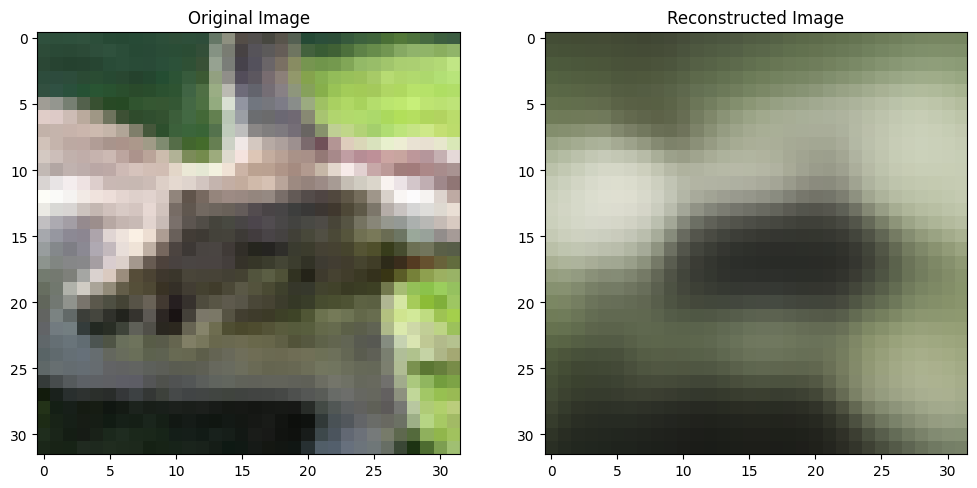

In [23]:
import matplotlib.pyplot as plt
import numpy as np

# Function to convert a tensor to a numpy array suitable for plotting
def tensor_to_plot(tensor, mean=0.5, std=0.5):
    # Clone the tensor, detach it from the computation graph, and move it to CPU
    tensor = tensor.clone().detach().cpu()
    # Denormalize the image
    tensor = tensor * std + mean  # assuming mean and std are scalars or same shape as the channels
    # Convert to numpy and move the channel to the last dimension
    tensor = tensor.numpy().transpose(1, 2, 0)
    # Clip values to ensure they are between 0 and 1, as they might have gone out of bounds due to arithmetic operations
    tensor = np.clip(tensor, 0, 1)
    return tensor

# Assuming 'image' is the original image tensor and 'reconstruction' is the output from the decoder
image_np = tensor_to_plot(image[0])  # [0] to remove the batch dimension
reconstruction = rearrange(reconstruction, 'b h w c -> b c h w')
reconstruction_np = tensor_to_plot(reconstruction[0])  # Assuming reconstruction is a tensor with batch dimension

# Plotting the original image
plt.figure(figsize=(12, 6))
plt.subplot(1, 2, 1)
plt.imshow(image_np)
plt.title('Original Image')

# Plotting the reconstructed image
plt.subplot(1, 2, 2)
plt.imshow(reconstruction_np)
plt.title('Reconstructed Image')

plt.show()

## Generative Modelling

Here we embed the entire dataset using a GMM, we then sample from this GMM and pass these embeddings through the decoder.

This section will be developed independently of any of the code above, such that we can apply it to any of our models.

Of course you will need to alter the merging schedule to reduce them to a single point.

If we end up having to make changes to the loss, like adding regularlisation, then I will update you here.

*Things I changed from the code above*

- Model saving

In [24]:
import numpy as np
from tqdm.notebook import tqdm, trange
from sklearn.mixture import GaussianMixture

In [25]:
# First we use our trained model to embed the dataset

embeddings = []  # List to store embeddings

for inputs in tqdm(train_loader):
    with torch.no_grad():
        images, _ = inputs
        images = images.to('cuda')
        output = encoder(images, schedule)  # Get embeddings from model
        embeddings.append(output.cpu().numpy())  # Convert to NumPy array and store

# Convert list of arrays to a single NumPy array
embeddings = np.concatenate(embeddings, axis=0)

print(embeddings.shape)

  0%|          | 0/390 [00:00<?, ?it/s]

(49920, 1, 256)


In [26]:
embeddings = np.squeeze(embeddings, axis=1)
print(embeddings.shape)

(49920, 256)


In [ ]:
# Then we fit a bunch of Guassian Mixture Models to this embedded dataset and pick the best one

n_components_range = range(1, 21)
bics = []
aics = []

for n_components in tqdm(n_components_range):
    # Fit a Gaussian mixture with EM
    gmm = GaussianMixture(n_components=n_components, covariance_type='full', random_state=42)
    gmm.fit(embeddings)
    bics.append(gmm.bic(embeddings))
    aics.append(gmm.aic(embeddings))

# Plotting the results
plt.figure(figsize=(18, 6))

plt.subplot(1, 2, 1)
plt.plot(n_components_range, bics, label='BIC')
plt.xlabel('Number of Components')
plt.ylabel('BIC')
plt.legend()

plt.subplot(1, 2, 2)
plt.plot(n_components_range, aics, label='AIC')
plt.xlabel('Number of Components')
plt.ylabel('AIC')
plt.legend()

plt.show()

In [27]:
# The experiment revealed that n_components= is best

n_components = 5

gmm = GaussianMixture(n_components=n_components, covariance_type='full', random_state=42)
gmm.fit(embeddings)

/usr/local/lib/python3.10/dist-packages/sklearn/mixture/_base.py:274: ConvergenceWarning: Initialization 1 did not converge. Try different init parameters, or increase max_iter, tol or check for degenerate data.
  warnings.warn(


GaussianMixture(n_components=5, random_state=42)

In [37]:
# Next we sample from this Guassian Mixture Model to obtain new points in the latent space

n_samples = 100
new_embeddings, _ = gmm.sample(n_samples)

In [38]:
# Here we pass a couple of these through the decoder and plot the outputs
print(new_embeddings.shape)


(100, 256)


In [39]:
samples = np.expand_dims(new_embeddings, axis=1).astype(np.float32)

samples = torch.from_numpy(samples)

print(samples.shape)

torch.Size([100, 1, 256])


In [40]:
samples = samples.to('cuda')

reconstructions = decoder(samples, schedule)

print(reconstructions.shape)

torch.Size([100, 32, 32, 3])


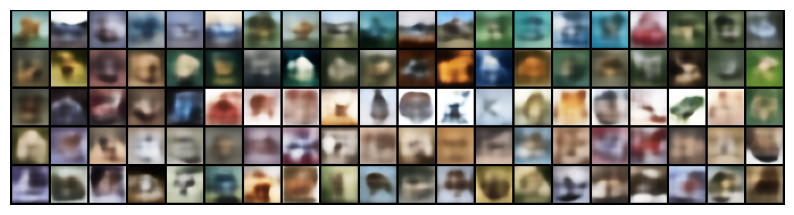

In [42]:
recon = reconstructions.detach().add(1).div(2).clamp(0, 1).cpu()

recon = recon.permute(0, 3, 1, 2)  # Adjust if your tensor isn't in the (B,C,H,W) format

# Create a grid of images
grid = torchvision.utils.make_grid(recon, nrow=20)  # nrow is the number of images displayed in a row

# Convert the grid tensor to a numpy array and transpose it for displaying
grid_np = grid.numpy().transpose((1, 2, 0))

# Display the images grid
plt.figure(figsize=(10, 10))
plt.imshow(grid_np)
plt.axis('off')  # Turn off the axis to display only the images
plt.show()

In [ ]:
wandb.finish()